# Human Activity Recognition

Several devices track human physical activity by analyzing the output of sensors attached to the body—commonly a 3-axis accelerometer in a phone carried in a hip pocket. Applications include calculating calories burned, reducing sedentary behavior, and patient monitoring in assistent living scenarios.

This analysis is based on a [2012 study](http://groupware.les.inf.puc-rio.br/har) that gathered data from 4 3-axis accelerometers for the purpose of creating a public benchmark for human activity recognition research. The accelerometers were positioned on each subject:

1. Waist
2. Thigh (left)
3. Ankle (right)
4. Upper arm (right)

In [1]:
import catboost as cb
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import sklearn.decomposition as dc
import sklearn.ensemble as ens
import sklearn.linear_model as lm
import sklearn.metrics as met
import sklearn.model_selection as ms
import sklearn.preprocessing as pre
import sklearn.svm as svm
import sklearn.tree as tree
import skopt
import skopt.space as sp
import time
import warnings
import xgboost as xgb

%matplotlib inline
%load_ext nb_black

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
# load data
# source: http://groupware.les.inf.puc-rio.br/har
url = "Data/dataset-har-PUC-Rio-ugulino.csv"
# url = "https://drive.google.com/uc?export=download&id=1nJnMVuxUdQB_zCGj2p-zaNIklZS8vHlR"
df = pd.read_csv(url, sep=";")

<IPython.core.display.Javascript object>

The data only includes 4 subjects, and this only 4 values in each of the `user`, `gender`, `age`, `how_tall_in_meters`, `weight`, and `body_mass_index` columns. We also want our model to work without knowing anything about the person using it. So these columns are excluded from the analysis.

The remaining columns are 4 sets of accelerometer readings (`x`, `y`, `z`) and the physical activity to predict (`class`).

In [3]:
accel_columns = []
for i in range(1, 5):
    accel_columns.append(f"x{i}")
    accel_columns.append(f"y{i}")
    accel_columns.append(f"z{i}")

data = df[["class"] + accel_columns].copy()

<IPython.core.display.Javascript object>

In [4]:
# z4 contains some non-numeric data
def count_column_nonnumbers(df, column_name):
    mask = df[[column_name]].applymap(lambda x: not np.isreal(x))[column_name]
    column = df[mask.to_list()][column_name]
    if column is None:
        return 0
    else:
        return len(column)


n_strings = count_column_nonnumbers(data, "z4")
print(f"There are {n_strings} non-numeric values in z4")

There are 32768 non-numeric values in z4


<IPython.core.display.Javascript object>

In [5]:
# convert z4 strings to int where possible
int_z4 = []
for x in df["z4"]:
    try:
        x_int = int(x)
    except:
        # non-numeric data includes one row with a concatenated datetime
        if x[0] == "-":
            x_int = int(x[:4])
        else:
            x_int = int(x[:3])
    int_z4.append(x_int)

data["z4"] = int_z4
n_strings = count_column_nonnumbers(data, "z4")
print(f"There are {n_strings} non-numeric values in z4")

There are 0 non-numeric values in z4


<IPython.core.display.Javascript object>

In [6]:
data.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
count,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000,165633.000000
mean,-6.649327,88.293667,-93.164611,-87.827504,-52.065047,-175.055200,17.423515,104.517167,-93.881726,-167.641448,-92.625171,-159.650891
std,11.616238,23.895829,39.409423,169.435194,205.159763,192.816615,52.635388,54.155843,45.389646,38.311342,19.968610,13.221036
min,-306.000000,-271.000000,-603.000000,-494.000000,-517.000000,-617.000000,-499.000000,-506.000000,-613.000000,-702.000000,-526.000000,-537.000000
25%,-12.000000,78.000000,-120.000000,-35.000000,-29.000000,-141.000000,9.000000,95.000000,-103.000000,-190.000000,-103.000000,-167.000000
50%,-6.000000,94.000000,-98.000000,-9.000000,27.000000,-118.000000,22.000000,107.000000,-90.000000,-168.000000,-91.000000,-160.000000
75%,0.000000,101.000000,-64.000000,4.000000,86.000000,-29.000000,34.000000,120.000000,-80.000000,-153.000000,-80.000000,-153.000000
max,509.000000,533.000000,411.000000,473.000000,295.000000,122.000000,507.000000,517.000000,410.000000,-13.000000,86.000000,-43.000000


<IPython.core.display.Javascript object>

In [7]:
def new_describe_stats():
    return {
        "variable": [],
        "nobs": [],
        "min": [],
        "max": [],
        "median": [],
        "mean": [],
        "variance": [],
        "skewness": [],
        "kurtosis": [],
    }


def append_describe_stats(describe_stats, df, column_name):
    stats = st.describe(df[column_name])
    describe_stats["variable"].append(column_name)
    describe_stats["nobs"].append(stats[0])
    describe_stats["min"].append(stats[1][0])
    describe_stats["max"].append(stats[1][1])
    describe_stats["median"].append(df[column_name].median())
    describe_stats["mean"].append(stats[2])
    describe_stats["variance"].append(stats[3])
    describe_stats["skewness"].append(stats[4])
    describe_stats["kurtosis"].append(stats[5])


describe_stats = new_describe_stats()
for column in accel_columns:
    append_describe_stats(describe_stats, data, column)

describe_data = pd.DataFrame(describe_stats)
describe_data

,variable,nobs,min,max,median,mean,variance,skewness,kurtosis
0,x1,165633,-306,509,-6.0,-6.649327,134.936986,0.232617,28.077956
1,y1,165633,-271,533,94.0,88.293667,571.010642,-0.915444,2.714290
2,z1,165633,-603,411,-98.0,-93.164611,1553.102655,-0.360759,7.345755
3,x2,165633,-494,473,-9.0,-87.827504,28708.284900,-1.590703,0.936651
4,y2,165633,-517,295,27.0,-52.065047,42090.528420,-1.419668,0.429350
5,z2,165633,-617,122,-118.0,-175.055200,37178.246911,-1.408083,0.528990
6,x3,165633,-499,507,22.0,17.423515,2770.484021,-3.689059,35.647761
7,y3,165633,-506,517,107.0,104.517167,2932.855278,-5.547995,60.578206
8,z3,165633,-613,410,-90.0,-93.881726,2060.219976,-5.512793,62.722159
9,x4,165633,-702,-13,-168.0,-167.641448,1467.758925,-1.040640,18.365515


<IPython.core.display.Javascript object>

<Figure size 1440x1440 with 0 Axes>

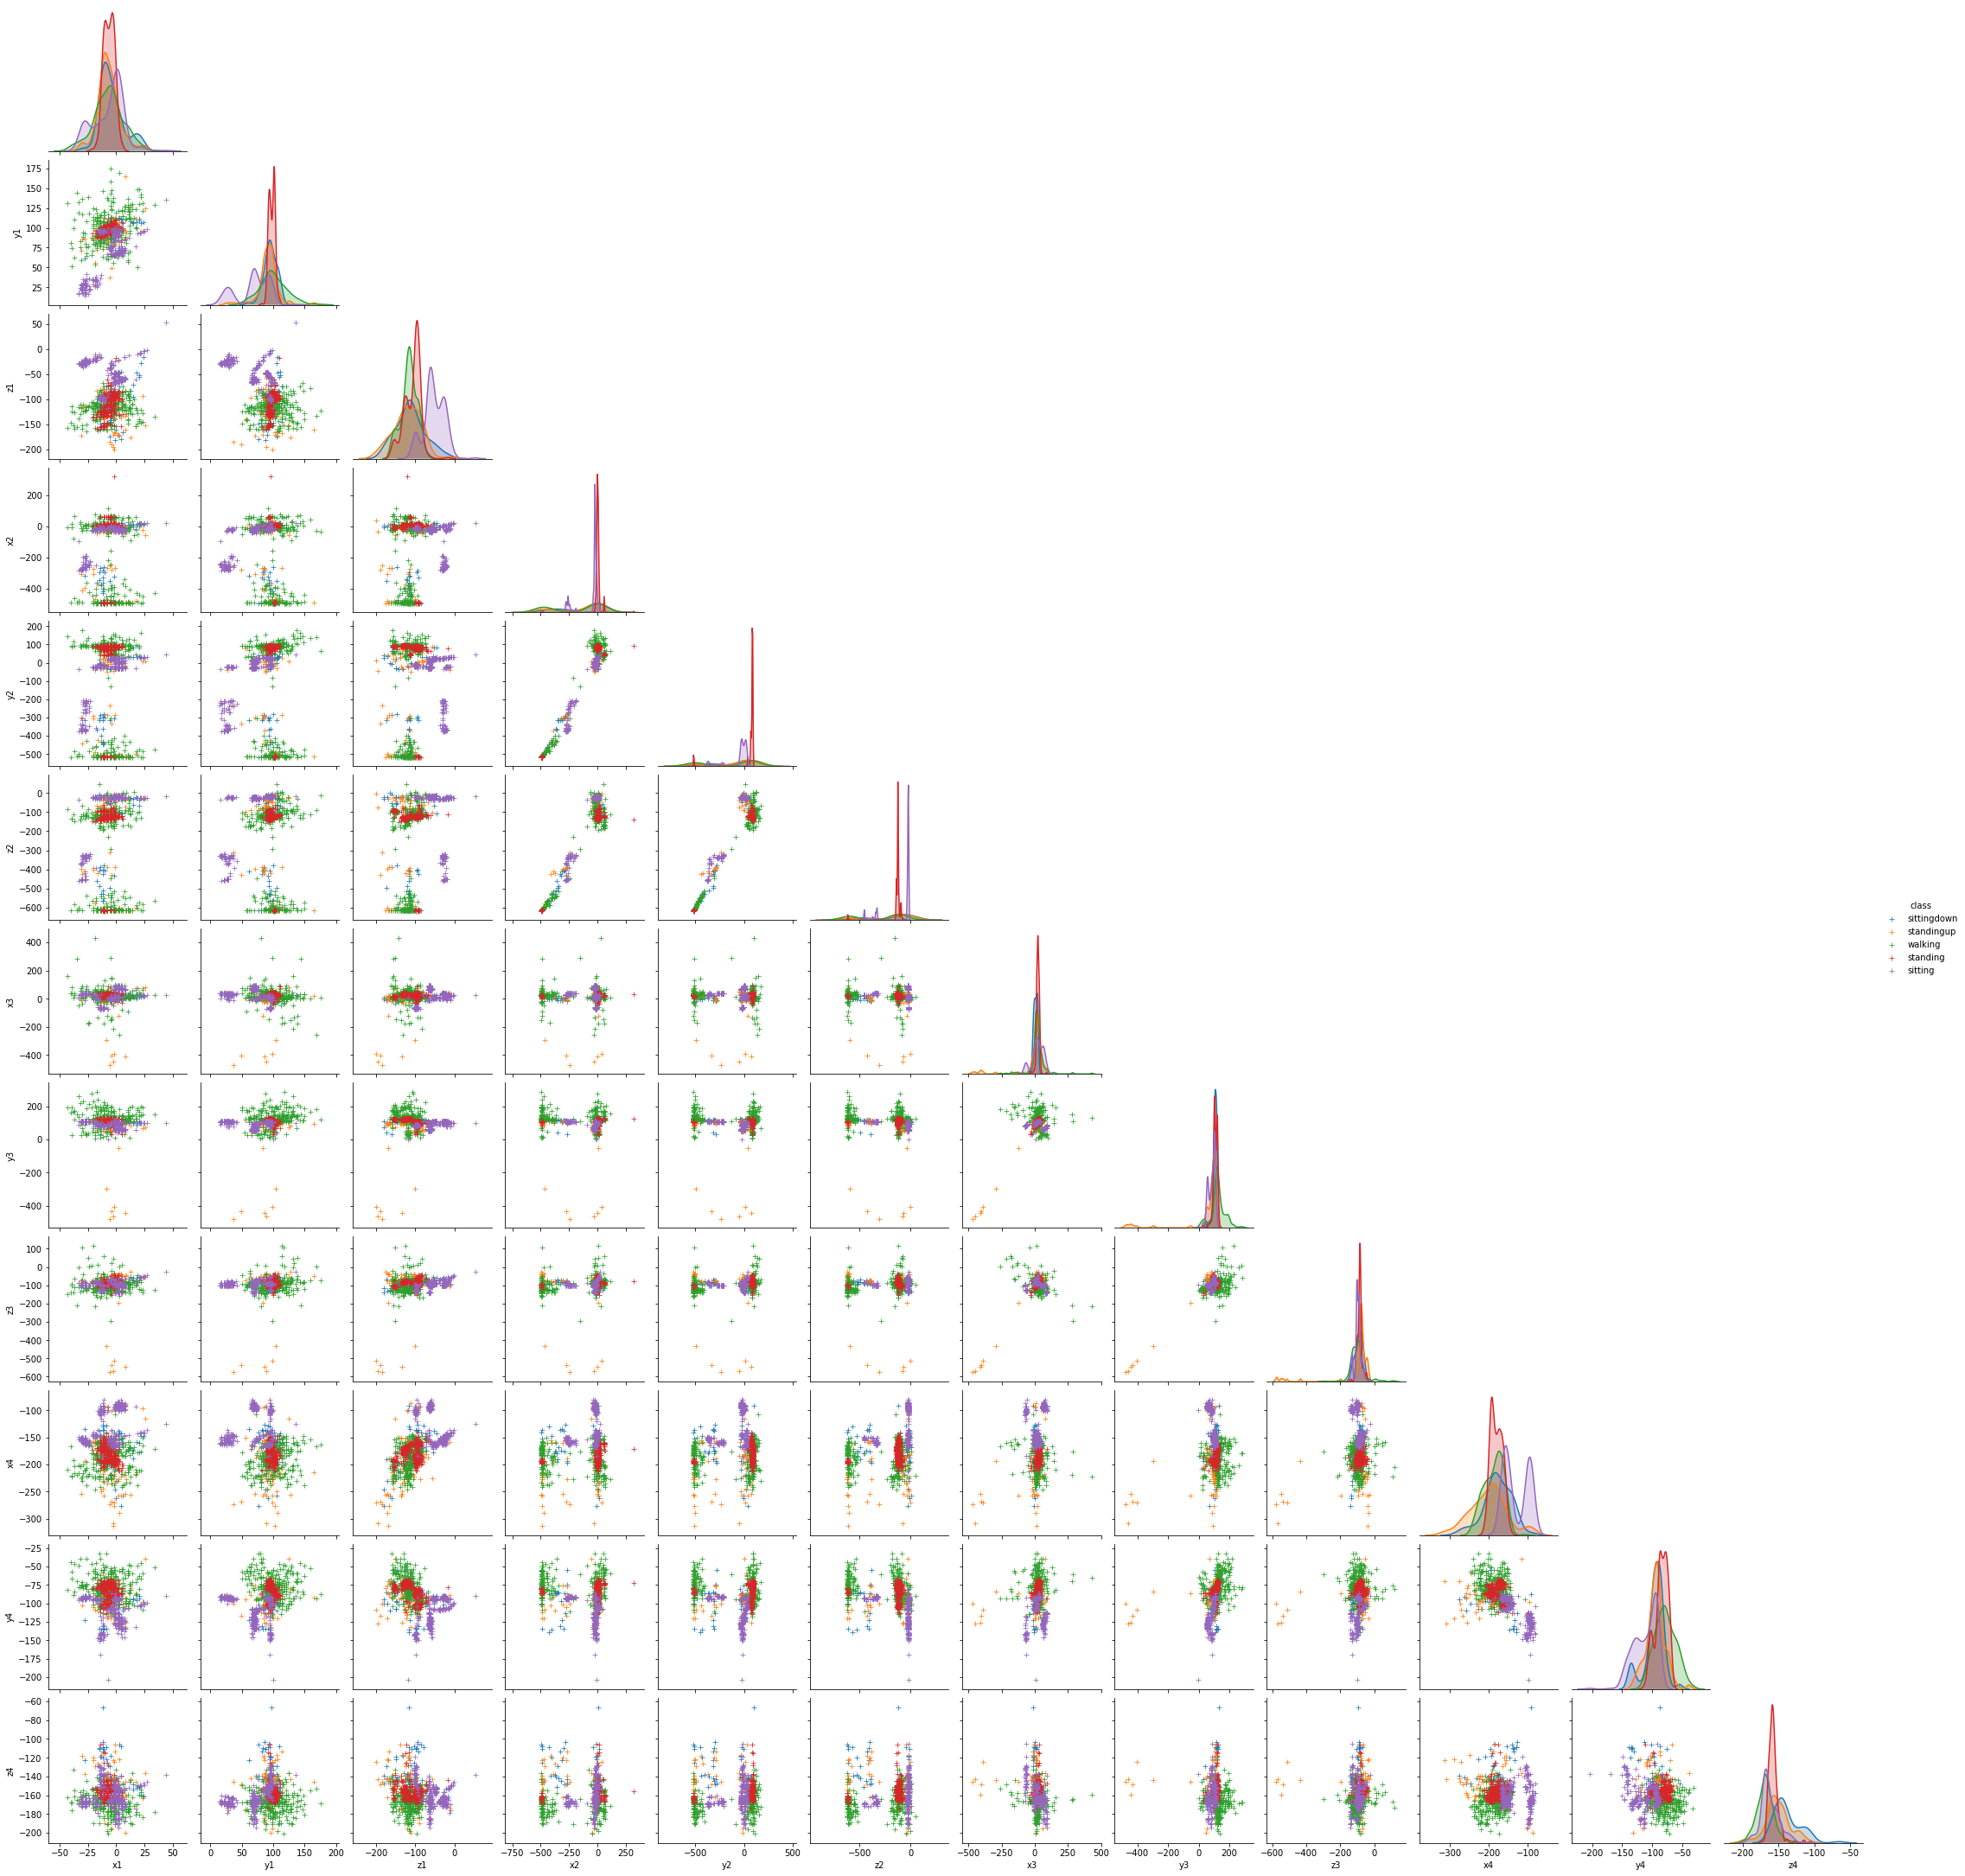

<IPython.core.display.Javascript object>

In [8]:
plot_data = data.sample(n=1000)
class_order = ["sittingdown", "standingup", "walking", "standing", "sitting"]

plt.figure(figsize=(20, 20))
sns.pairplot(plot_data, corner=True, hue="class", hue_order=class_order, markers="+")
plt.show()

The `sitting` activity shows distinct clusters in several univariate and bivariate plots, especially from the waist-mounted accelerometer. That class should be easy to distinguish from the others.

Bivariate plots show strong colinearity among the thigh-mounted accelerometer axes (`x2`, `y2`, `z2`).

Data for the `walking` class show wide dispersion (unsurprisingly), which might make that outcome difficult to distinguish from the other classes. `walking` might turn out to be a "default" that classifiers revert to when they cannot positively identify a sample as any other class.

## Modeling

I begin modeling by attempting to reproduce the results achieved by the original research group using AdaBoost.

In [9]:
# modeling-evaluation split
eval_size = 0.2
X_model, X_eval, y_model, y_eval = ms.train_test_split(
    data[accel_columns], data["class"], test_size=eval_size
)

<IPython.core.display.Javascript object>

In [10]:
# subsample data to make training faster and for hyperparameter tuning
model_n = len(X_model)
train_n = 50000
train_size = min(train_n / model_n, 0.9)
X_train, X_test, y_train, y_test = ms.train_test_split(
    X_model, y_model, test_size=(1 - train_size)
)

<IPython.core.display.Javascript object>

In [11]:
# plotting functions
def despine_all():
    sns.despine(top=True, left=True, right=True)


def figure_is_widescreen():
    plt.figure(figsize=(16, 9))


def barplot_classifier_scores(score_df):
    barplot_data = score_df.sort_values("test accuracy", ascending=False)

    sns.set_style("whitegrid")
    figure_is_widescreen()
    sns.barplot(x="model", y="test accuracy", data=barplot_data)
    despine_all()
    plt.title("Model Performance Comparison")
    plt.show()


def plot_confusion_matrix(
    cm, target_names, title="Confusion matrix", cmap=None, normalize=True
):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    sns.set_style("white")
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

<IPython.core.display.Javascript object>

In [12]:
# scoring & comparison functions


def param_columns(search_results_df):
    """Return names of param_* columns from a fit *SearchCV model"""
    return [x for x in search_results_df.columns if "param_" in x]


def search_cv_result(trained_search):
    """Return DataFrame of parameters & performances from a fit *SearchCV model"""
    df = pd.DataFrame(trained_search.cv_results_).sort_values(
        "rank_test_score", ascending=True
    )
    columns = ["mean_test_score"] + param_columns(df)
    return df[columns]


default_labels = ["sitting", "sittingdown", "standing", "standingup", "walking"]


def report_scores(
    model, X_train, y_train, X_test, y_test, name=None, labels=default_labels
):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    if name is None:
        print(f"Train: {train_score:.4f}, Test: {test_score:.4f}")
    else:
        print(f"{name}: Train: {train_score:.4f}, Test: {test_score:.4f}")

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    print(met.classification_report(y_test, test_predict))

    cm = met.confusion_matrix(y_test, test_predict)
    plot_confusion_matrix(cm, labels)

    new_row = {
        "model": name,
        "train accuracy": met.accuracy_score(y_train, train_predict),
        "test accuracy": met.accuracy_score(y_test, test_predict),
        "test f1 score": met.f1_score(y_test, test_predict, average="weighted"),
    }
    return new_row


def new_classifier_score_df():
    return pd.DataFrame(
        {"model": [], "train accuracy": [], "test accuracy": [], "test f1 score": []}
    )

<IPython.core.display.Javascript object>

In [13]:
# save classification scores for comparison
classifier_score_df = new_classifier_score_df()

<IPython.core.display.Javascript object>

In [14]:
# # tune AdaBoost with Bayesian search, commented out to avoid long runtime
# # hyper-hyperparameters
# iterations = 100
# cv_folds = 3

# ada = ens.AdaBoostClassifier(tree.DecisionTreeClassifier())
# hyperparameters = {
#     "base_estimator__max_depth": sp.Integer(2, 6, prior="log-uniform"),
#     "n_estimators": sp.Integer(50, 300),
#     "learning_rate": sp.Real(0.1, 0.9),
# }

# ada_bayes = skopt.BayesSearchCV(
#     ada, hyperparameters, cv=cv_folds, n_iter=iterations, n_jobs=-1
# )
# ada_bayes.fit(X_train, y_train)

# search_cv_result(ada_bayes).head(20)

<IPython.core.display.Javascript object>

AdaBoost: Train: 0.9990, Test: 0.9930
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     25321
 sittingdown       0.97      0.98      0.97      5884
    standing       1.00      1.00      1.00     23524
  standingup       0.97      0.96      0.97      6150
     walking       0.99      1.00      0.99     21628

    accuracy                           0.99     82507
   macro avg       0.99      0.99      0.99     82507
weighted avg       0.99      0.99      0.99     82507



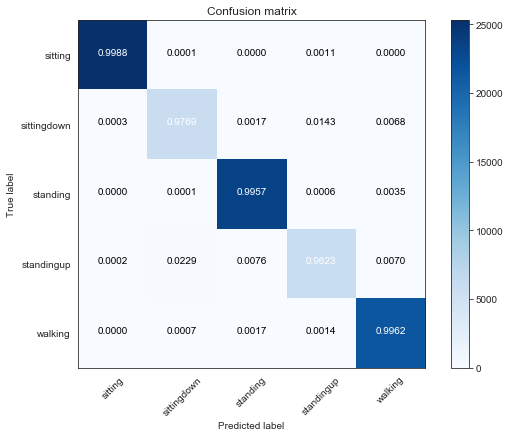

<IPython.core.display.Javascript object>

In [15]:
# fit AdaBoost model (hyperparameters tuned above)
dt = tree.DecisionTreeClassifier(max_depth=7, max_leaf_nodes=83)
ada = ens.AdaBoostClassifier(dt, learning_rate=0.9, n_estimators=1000)
ada.fit(X_train, y_train)
_ = report_scores(ada, X_train, y_train, X_test, y_test, "AdaBoost")

The fit AdaBoost classifier shows worse performance on _sittingdown_ and _standingup_ than for the other outcome classes, and the model (understandably) confuses them with each other more often than other class pairs. In application, it would be easy to deduce these classes by observing a sequence from _sitting_ to _standing_ (for _standingup_), or vice versa. So I omit those classes from my modeling efforts

In [16]:
# ignore "sittingdown" and "standingup" classes
target_labels = ["sitting", "standing", "walking"]
data = data[data["class"].isin(target_labels)]

# modeling-evaluation split
X_model, X_eval, y_model, y_eval = ms.train_test_split(
    data[accel_columns], data["class"], test_size=eval_size
)

<IPython.core.display.Javascript object>

<Figure size 1440x1440 with 0 Axes>

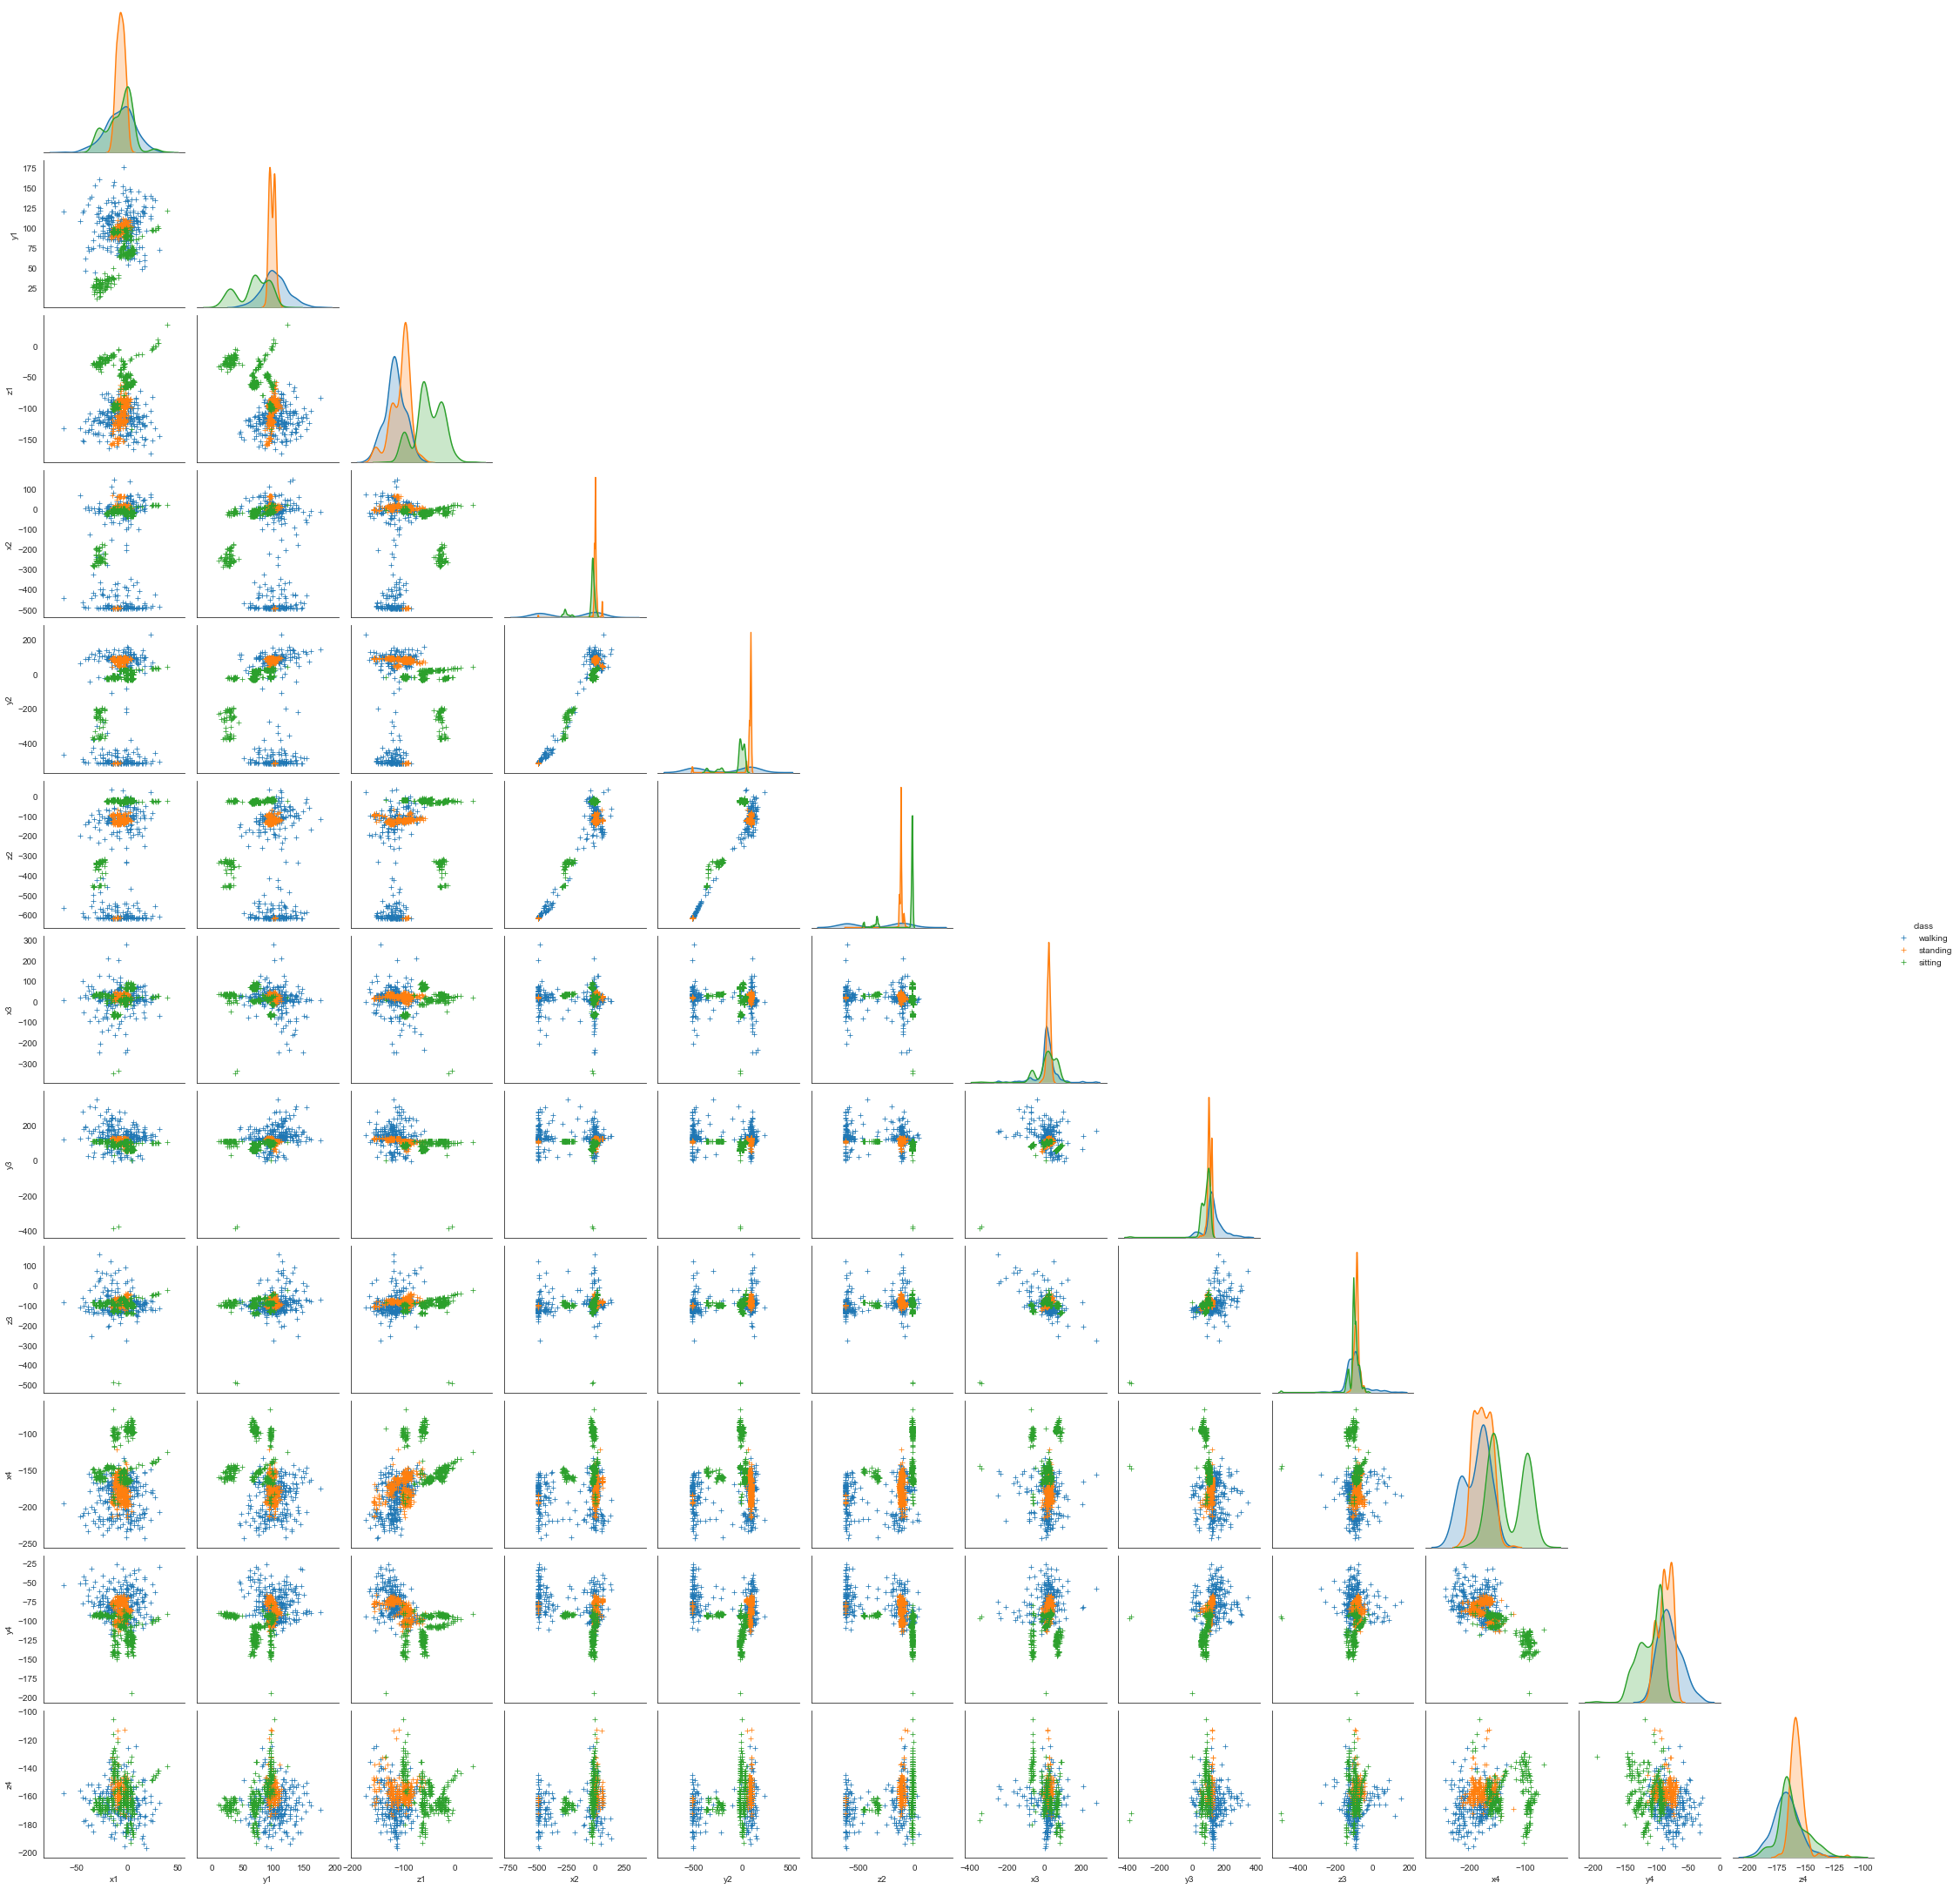

<IPython.core.display.Javascript object>

In [17]:
plot_data = data.sample(n=1000)
class_order = ["walking", "standing", "sitting"]

plt.figure(figsize=(20, 20))
sns.pairplot(plot_data, corner=True, hue="class", hue_order=class_order, markers="+")
plt.show()

In [18]:
# sample data to make training faster
model_n = len(X_model)
train_size = min(train_n / model_n, 0.9)
X_train, X_test, y_train, y_test = ms.train_test_split(
    X_model, y_model, test_size=(1 - train_size)
)

<IPython.core.display.Javascript object>

AdaBoost: Train: 1.0000, Test: 0.9987
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     22541
    standing       1.00      1.00      1.00     21118
     walking       1.00      1.00      1.00     19454

    accuracy                           1.00     63113
   macro avg       1.00      1.00      1.00     63113
weighted avg       1.00      1.00      1.00     63113



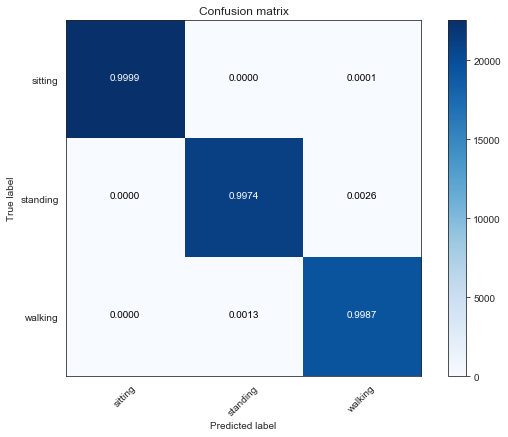

<IPython.core.display.Javascript object>

In [19]:
# fit AdaBoost model with reduced-label data
dt = tree.DecisionTreeClassifier(max_depth=6)
ada = ens.AdaBoostClassifier(dt, learning_rate=0.9, n_estimators=1000)
ada.fit(X_train, y_train)

new_score_row = report_scores(
    ada, X_train, y_train, X_test, y_test, "AdaBoost", labels=target_labels
)
classifier_score_df = classifier_score_df.append(new_score_row, ignore_index=True)

In [20]:
# scale data for logistic regression
scaler = pre.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [21]:
# # tune logistic regression with Bayesian search, commented out to avoid long runtime
# lr = lm.LogisticRegression(max_iter=1000, solver="saga")
# hyperparameters = {
#     "C": sp.Real(0.0001, 100, prior="log-uniform"),
#     "multi_class": sp.Categorical(["ovr", "multinomial"]),
#     "penalty": sp.Categorical(["none", "l1", "l2", "elasticnet"]),
#     "l1_ratio": sp.Real(0.1, 0.9),
# }

# lr_bayes = skopt.BayesSearchCV(
#     lr, hyperparameters, cv=cv_folds, n_iter=iterations, n_jobs=-1
# )
# lr_bayes.fit(X_train_scaled, y_train)

# search_cv_result(lr_bayes).head(20)

<IPython.core.display.Javascript object>

In [22]:
# fit logistic regression model
lr = lm.LogisticRegression(
    C=0.01288575264840049, max_iter=1000, solver="saga", multi_class="ovr", penalty="l2"
)
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01288575264840049, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

Logistic Regression: Train: 0.8800, Test: 0.8791
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     22541
    standing       0.78      0.90      0.83     21118
     walking       0.87      0.72      0.79     19454

    accuracy                           0.88     63113
   macro avg       0.88      0.87      0.87     63113
weighted avg       0.88      0.88      0.88     63113



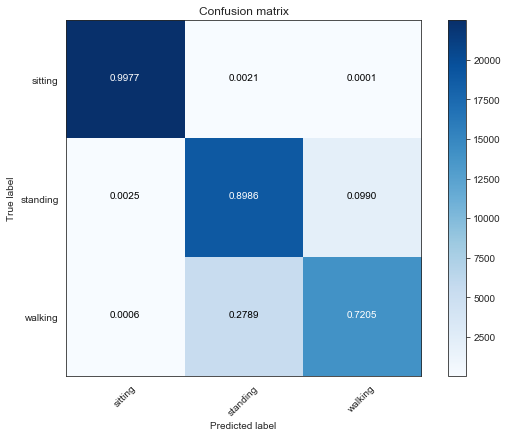

<IPython.core.display.Javascript object>

In [23]:
new_score_row = report_scores(
    lr,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    "Logistic Regression",
    labels=target_labels,
)
classifier_score_df = classifier_score_df.append(new_score_row, ignore_index=True)

In [24]:
# fit logistic regression model with PCA
pca = dc.PCA(n_components="mle")
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lr_pca = lm.LogisticRegression(
    C=1, max_iter=1000, solver="saga", multi_class="ovr", penalty="l2"
)
lr_pca.fit(X_train_pca, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

PCA, Logistic Regression: Train: 0.8752, Test: 0.8743
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     22541
    standing       0.77      0.88      0.83     21118
     walking       0.85      0.72      0.78     19454

    accuracy                           0.87     63113
   macro avg       0.87      0.87      0.87     63113
weighted avg       0.88      0.87      0.87     63113



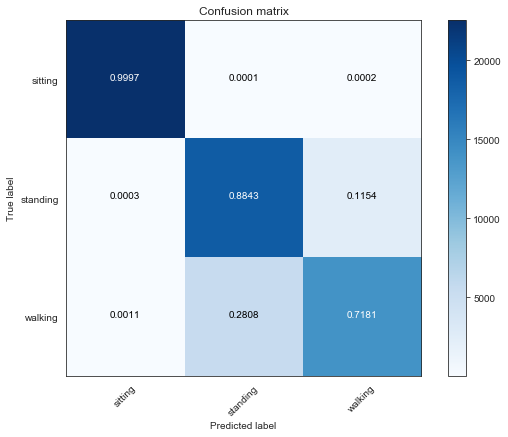

<IPython.core.display.Javascript object>

In [25]:
_ = report_scores(
    lr_pca,
    X_train_pca,
    y_train,
    X_test_pca,
    y_test,
    "PCA, Logistic Regression",
    labels=target_labels,
)

In [26]:
# # tune random forest with Bayesian search, commented out to avoid long runtime
# f = ens.RandomForestClassifier(n_jobs=-1)
# hyperparameters = {
#     "criterion": sp.Categorical(["gini", "entropy"]),
#     "n_estimators": sp.Integer(50, 1000, prior="log-uniform"),
#     "max_depth": sp.Integer(2, 6, prior="log-uniform"),
# }

# forest_bayes = skopt.BayesSearchCV(
#     f, hyperparameters, cv=cv_folds, n_iter=iterations, n_jobs=-1
# )
# forest_bayes.fit(X_train, y_train)

# search_cv_result(forest_bayes).head(20)

<IPython.core.display.Javascript object>

In [27]:
# fit random forest model
forest = ens.RandomForestClassifier(
    n_estimators=1000, criterion="entropy", max_depth=7, max_leaf_nodes=83, n_jobs=-1
)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=83, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

<IPython.core.display.Javascript object>

Random Forest: Train: 0.9866, Test: 0.9857
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     22541
    standing       0.97      0.99      0.98     21118
     walking       0.99      0.96      0.98     19454

    accuracy                           0.99     63113
   macro avg       0.99      0.98      0.99     63113
weighted avg       0.99      0.99      0.99     63113



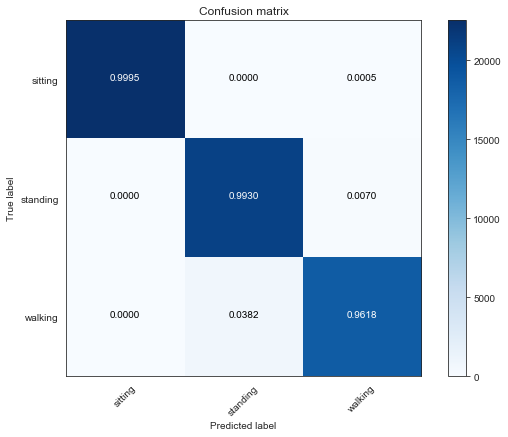

<IPython.core.display.Javascript object>

In [28]:
new_score_row = report_scores(
    forest, X_train, y_train, X_test, y_test, "Random Forest", labels=target_labels,
)
classifier_score_df = classifier_score_df.append(new_score_row, ignore_index=True)

In [29]:
# # tune CatBoost with Bayesian search, commented out to avoid long runtime
# cat = cb.CatBoostClassifier(verbose=False, thread_count=-1)
# hyperparameters = {
#     "early_stopping_rounds": sp.Integer(5, 50, prior="log-uniform"),
#     "learning_rate": sp.Real(0.001, 0.9, prior="log-uniform"),
#     "max_depth": sp.Integer(2, 6, prior="log-uniform"),
#     "n_estimators": sp.Integer(10, 1000, prior="log-uniform"),
# }

# cat_bayes = skopt.BayesSearchCV(
#     cat, hyperparameters, cv=cv_folds, n_iter=iterations, n_jobs=-1
# )
# cat_bayes.fit(X_train, y_train)

# search_cv_result(cat_bayes).head(20)

<IPython.core.display.Javascript object>

In [30]:
# fit CatBoost model
cat_hyperparameters = {
    "learning_rate": 0.49712744837202827,
    "max_depth": 6,
    "n_estimators": 513,
    "verbose": False,
    "early_stopping_rounds": 49,
    "thread_count": -1,
}
cat = cb.CatBoostClassifier(**cat_hyperparameters)
cat.fit(X_train, y_train)

<IPython.core.display.Javascript object>

CatBoost: Train: 1.0000, Test: 0.9982
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     22541
    standing       1.00      1.00      1.00     21118
     walking       1.00      1.00      1.00     19454

    accuracy                           1.00     63113
   macro avg       1.00      1.00      1.00     63113
weighted avg       1.00      1.00      1.00     63113



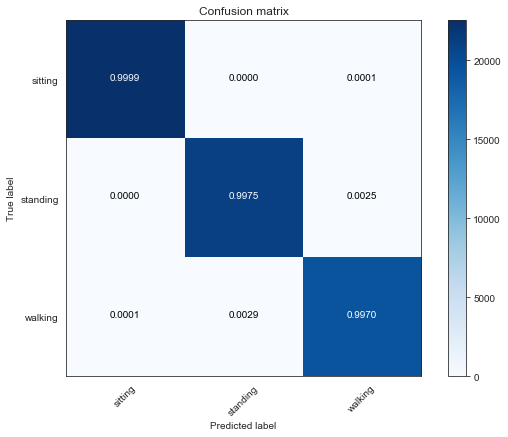

<IPython.core.display.Javascript object>

In [31]:
new_score_row = report_scores(
    cat, X_train, y_train, X_test, y_test, "CatBoost", labels=target_labels,
)
classifier_score_df = classifier_score_df.append(new_score_row, ignore_index=True)

In [32]:
# # tune support vector machine with Bayesian search, commented out to avoid long runtime
# svc = svm.SVC()
# hyperparameters = {
#     "C": sp.Real(0.001, 1000, prior="log-uniform"),
#     "kernel": sp.Categorical(["linear", "poly", "rbf", "sigmoid"]),
#     "degree": sp.Integer(2, 10, prior="log-uniform"),
# }

# svc_bayes = skopt.BayesSearchCV(
#     svc, hyperparameters, cv=cv_folds, n_iter=iterations, n_jobs=-1
# )
# svc_bayes.fit(X_train_scaled, y_train)

# search_cv_result(svc_bayes).head(20)

<IPython.core.display.Javascript object>

In [33]:
# fit SVM model
svc = svm.SVC(C=1, kernel="rbf")
svc.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

SVM: Train: 0.9451, Test: 0.9448
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     22541
    standing       0.86      0.99      0.92     21118
     walking       0.99      0.83      0.90     19454

    accuracy                           0.94     63113
   macro avg       0.95      0.94      0.94     63113
weighted avg       0.95      0.94      0.94     63113



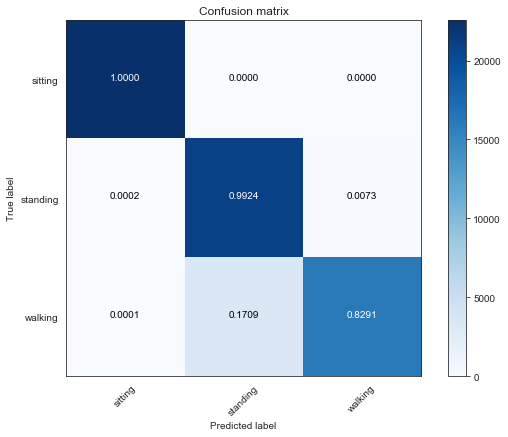

<IPython.core.display.Javascript object>

In [34]:
new_score_row = report_scores(
    svc, X_train, y_train, X_test, y_test, "SVM", labels=target_labels,
)
classifier_score_df = classifier_score_df.append(new_score_row, ignore_index=True)

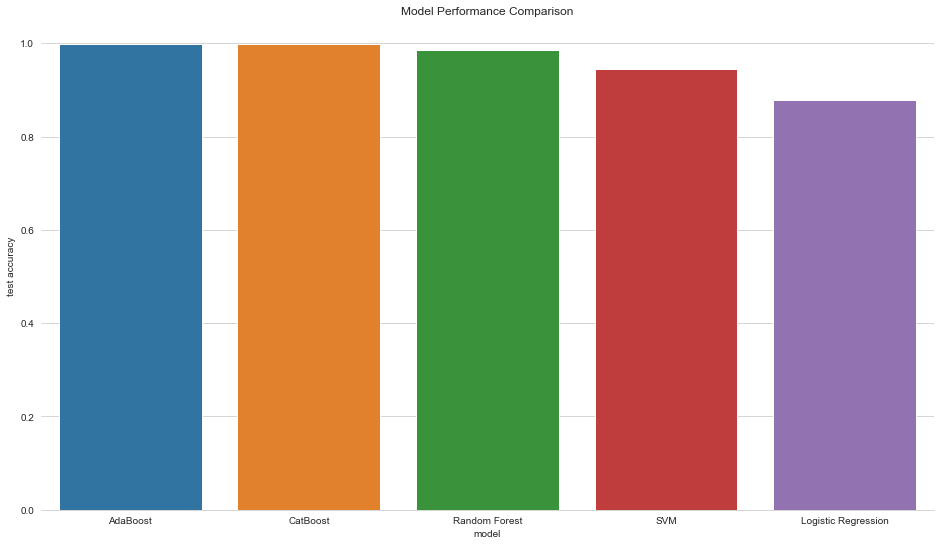

<IPython.core.display.Javascript object>

In [35]:
barplot_classifier_scores(classifier_score_df)

## Sensor Location

These models are based on 4 sensor locations. Due to cost and convenience constraints, we would like to achieve good results with fewer sensors, and typically only have one sensor location to work with for most applications. Common sensors are placed in a phone in a person's hip pocket (comparable to the thigh location in this data) or a watch on the wrist (which has no analogue in this data set). I check the quality of model that can be produced with data from only one of these sensors at a time.

In [36]:
waist_columns = ["x1", "y1", "z1"]
thigh_columns = ["x2", "y2", "z2"]
ankle_columns = ["x3", "y3", "z3"]
arm_columns = ["x4", "y4", "z4"]

sensor_score_df = new_classifier_score_df()

<IPython.core.display.Javascript object>

<Figure size 1080x1080 with 0 Axes>

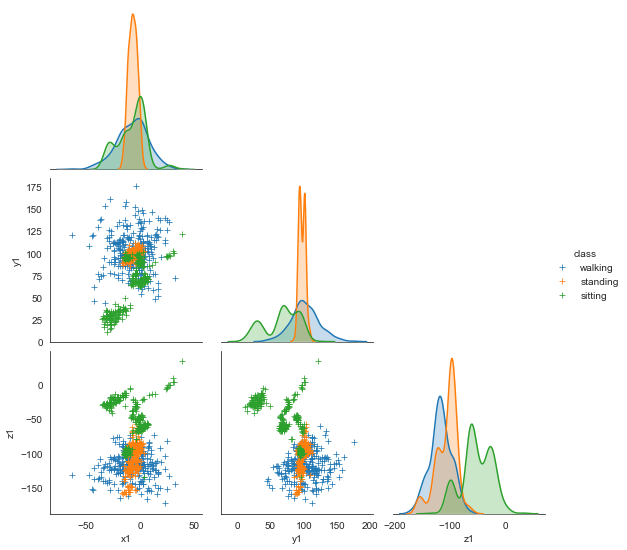

<IPython.core.display.Javascript object>

In [37]:
# plot waist sensor data
waist_data = plot_data[["class"] + waist_columns]
sns.set_style("white")
plt.figure(figsize=(15, 15))
sns.pairplot(waist_data, corner=True, hue="class", hue_order=class_order, markers="+")
plt.show()

CatBoost - Waist Only: Train: 0.9434, Test: 0.9314
              precision    recall  f1-score   support

     sitting       0.98      0.97      0.97     22541
    standing       0.89      0.93      0.91     21118
     walking       0.93      0.88      0.91     19454

    accuracy                           0.93     63113
   macro avg       0.93      0.93      0.93     63113
weighted avg       0.93      0.93      0.93     63113



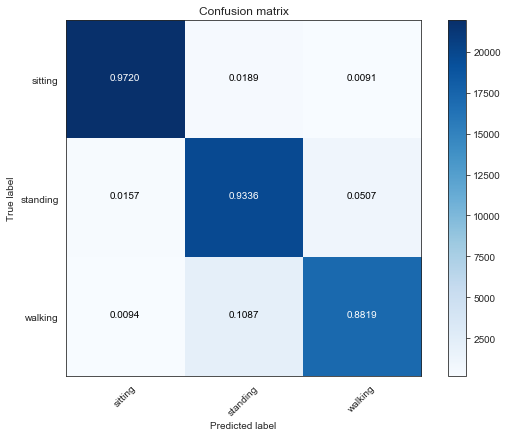

<IPython.core.display.Javascript object>

In [38]:
# fit waist sensor-specific model
cat_waist = cb.CatBoostClassifier(**cat_hyperparameters)
cat_waist.fit(X_train[waist_columns], y_train)
new_score_row = report_scores(
    cat_waist,
    X_train[waist_columns],
    y_train,
    X_test[waist_columns],
    y_test,
    "CatBoost - Waist Only",
    labels=target_labels,
)
sensor_score_df = sensor_score_df.append(new_score_row, ignore_index=True)

<Figure size 1080x1080 with 0 Axes>

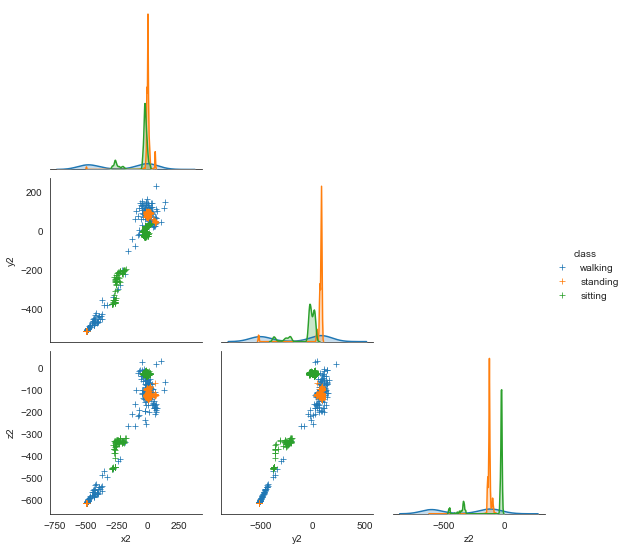

<IPython.core.display.Javascript object>

In [39]:
# plot thigh sensor data
thigh_data = plot_data[["class"] + thigh_columns]
plt.figure(figsize=(15, 15))
sns.pairplot(thigh_data, corner=True, hue="class", hue_order=class_order, markers="+")
plt.show()

CatBoost - Thigh Only: Train: 0.9638, Test: 0.9564
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     22541
    standing       0.93      0.94      0.94     21118
     walking       0.93      0.92      0.93     19454

    accuracy                           0.96     63113
   macro avg       0.95      0.95      0.95     63113
weighted avg       0.96      0.96      0.96     63113



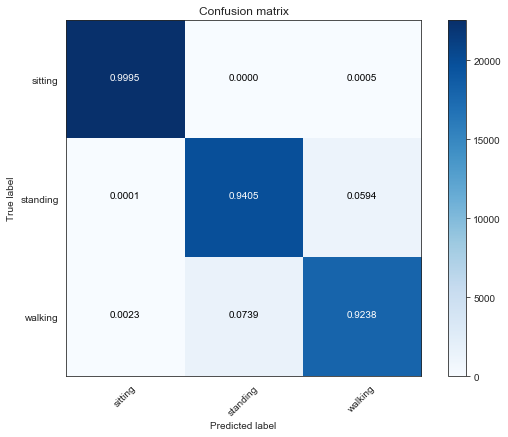

<IPython.core.display.Javascript object>

In [40]:
# fit thigh sensor-specific model
cat_thigh = cb.CatBoostClassifier(**cat_hyperparameters)
cat_thigh.fit(X_train[thigh_columns], y_train)
new_score_row = report_scores(
    cat_thigh,
    X_train[thigh_columns],
    y_train,
    X_test[thigh_columns],
    y_test,
    "CatBoost - Thigh Only",
    labels=target_labels,
)
sensor_score_df = sensor_score_df.append(new_score_row, ignore_index=True)

<Figure size 864x864 with 0 Axes>

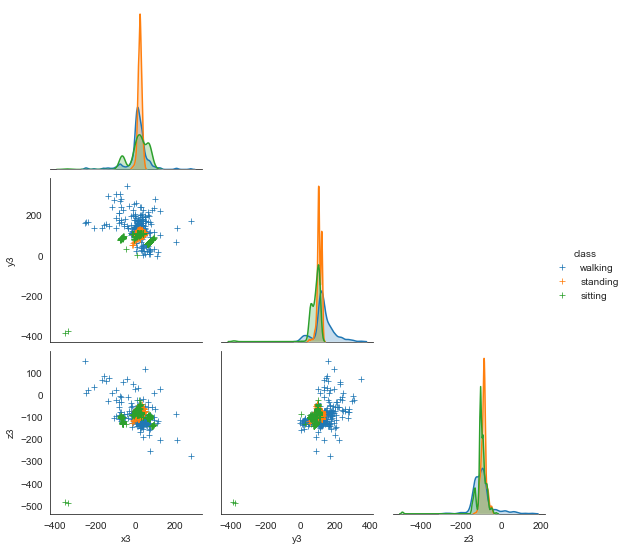

<IPython.core.display.Javascript object>

In [41]:
# plot ankle sensor data
ankle_data = plot_data[["class"] + ankle_columns]
plt.figure(figsize=(12, 12))
sns.pairplot(ankle_data, corner=True, hue="class", hue_order=class_order, markers="+")
plt.show()

CatBoost - Ankle Only: Train: 0.9737, Test: 0.9640
              precision    recall  f1-score   support

     sitting       0.97      0.99      0.98     22541
    standing       0.95      0.97      0.96     21118
     walking       0.97      0.94      0.95     19454

    accuracy                           0.96     63113
   macro avg       0.96      0.96      0.96     63113
weighted avg       0.96      0.96      0.96     63113



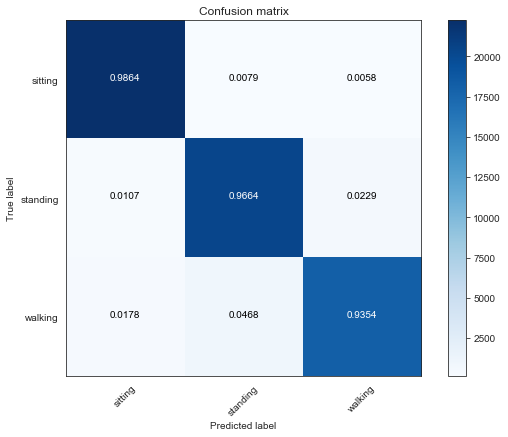

<IPython.core.display.Javascript object>

In [42]:
# fit ankle sensor-specific model
cat_ankle = cb.CatBoostClassifier(**cat_hyperparameters)
cat_ankle.fit(X_train[ankle_columns], y_train)
new_score_row = report_scores(
    cat_ankle,
    X_train[ankle_columns],
    y_train,
    X_test[ankle_columns],
    y_test,
    "CatBoost - Ankle Only",
    labels=target_labels,
)
sensor_score_df = sensor_score_df.append(new_score_row, ignore_index=True)

<Figure size 1080x1080 with 0 Axes>

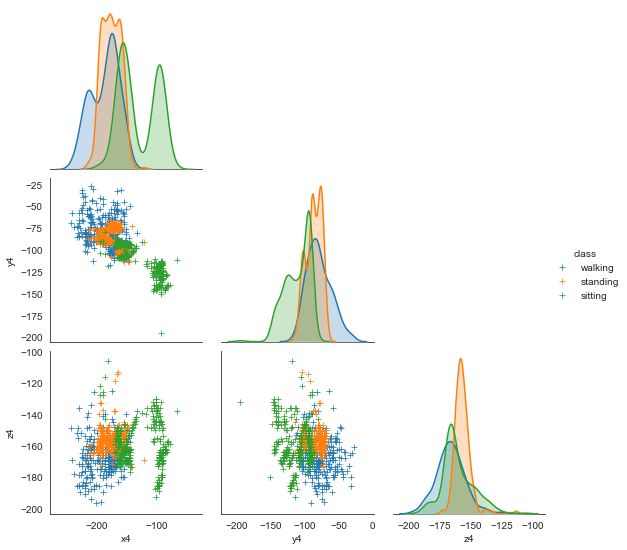

<IPython.core.display.Javascript object>

In [43]:
# plot arm sensor data
arm_data = plot_data[["class"] + arm_columns]
plt.figure(figsize=(15, 15))
sns.pairplot(arm_data, corner=True, hue="class", hue_order=class_order, markers="+")
plt.show()

CatBoost - Arm Only: Train: 0.9398, Test: 0.9215
              precision    recall  f1-score   support

     sitting       0.96      0.98      0.97     22541
    standing       0.88      0.93      0.91     21118
     walking       0.92      0.84      0.88     19454

    accuracy                           0.92     63113
   macro avg       0.92      0.92      0.92     63113
weighted avg       0.92      0.92      0.92     63113



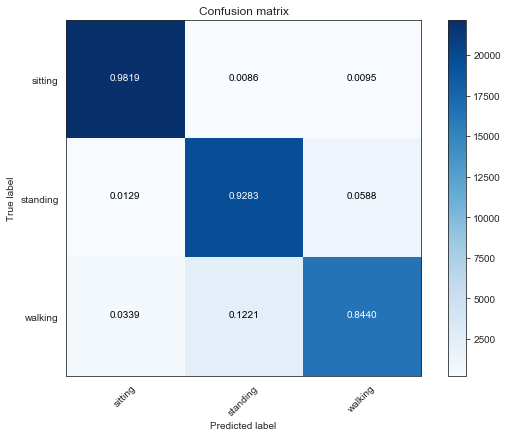

<IPython.core.display.Javascript object>

In [44]:
# fit arm sensor-specific model
cat_arm = cb.CatBoostClassifier(**cat_hyperparameters)
cat_arm.fit(X_train[arm_columns], y_train)
new_score_row = report_scores(
    cat_arm,
    X_train[arm_columns],
    y_train,
    X_test[arm_columns],
    y_test,
    "CatBoost - Arm Only",
    labels=target_labels,
)
sensor_score_df = sensor_score_df.append(new_score_row, ignore_index=True)

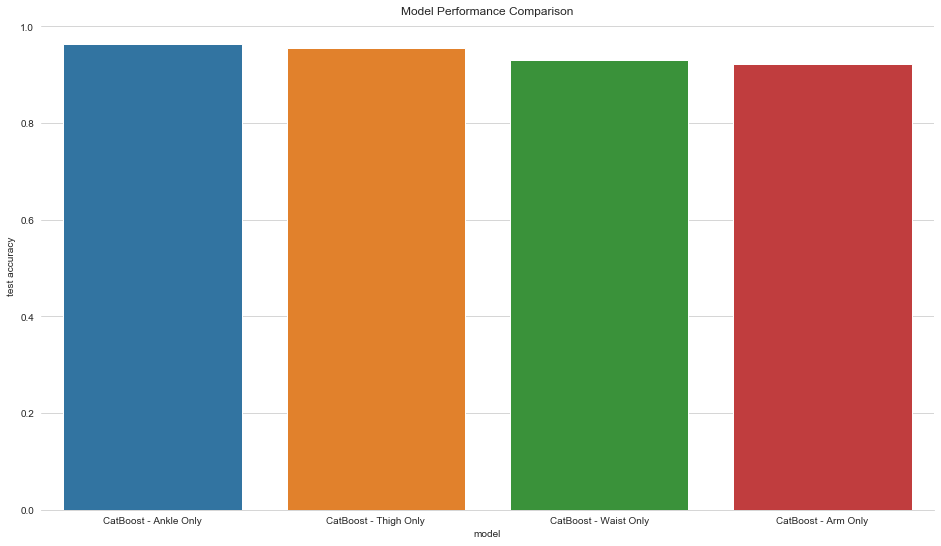

<IPython.core.display.Javascript object>

In [45]:
barplot_classifier_scores(sensor_score_df)

A model fit on only the thigh sensor data is more accurate than models fit on the waist or arm sensors. The thigh has the greatest change in orientation between sitting and standing.

The model fit on ankle sensor data is most accurate overall, though less accurate than the thigh sensor for distinguishing sitting from other classes. The ankle does not change orientation between sitting and standing as much as the thigh, but does show the most dramatic change between standing and walking.

I'm focusing on the thigh sensor for now. In practice, there are few activity monitoring products attached to the ankle. When a person already has a phone in their pocket, any additional devices (and costs) must add substantial value on top of what the phone can already do by itself. The model fit to the thigh sensor data is more accurate than the ankle sensor for distinguishing between sitting and not sitting, which may be a more important distinction for many users than between standing and walking where the ankle sensor leads to more accurate results.

## Accuracy vs. Speed

Is the thigh model accurate enough? Without a specific application in mind and user testing to validate the answer, this isn't a good question. All else being equal, more accuracy is better. All else is usually not equal. Many models, especially the ensemble models that performed best for this task, can easily improve accuracy by using more base learners (to a point). But this costs computation time, and, in turn, energy. For wearable sensors using inexpensive hardware and running on batteries, this is just as significant a concern. Without specific hardware with specific performance envelopes, the best we can do is describe the tradeoff between prediction accuracy vs. computation time (for predictions).

In [46]:
# Measure (adjusted, balanced) accuracy against tree sizes, counts, and predict times.
# Due to the iterative construction of Boosted models, we can test the accuracy for many
# different n_estimators values with one trained model.
cat_hyperparameters = {
    "learning_rate": 0.49712744837202827,
    "max_depth": 6,
    "n_estimators": 513,
    "verbose": False,
    "early_stopping_rounds": 49,
    "thread_count": -1,
}
tree_counts = np.arange(10, 501, 10)
max_depths = np.arange(2, 8)
n_timing_runs = 3

recorded_max_depths = []
recorded_tree_counts = []
recorded_times = []
recorded_scores = []

for d in max_depths:
    cat_hyperparameters["max_depth"] = d
    time_cat = cb.CatBoostClassifier(**cat_hyperparameters)
    time_cat.fit(X_train[thigh_columns], y_train)

    for n in tree_counts:
        run_times = []
        for _ in range(n_timing_runs):
            start = time.time()
            # thread_count=1 to approximate abilities of low-cost wearable hardware
            y_pred = time_cat.predict(
                X_test[thigh_columns], ntree_end=n, thread_count=1
            )
            elapsed = time.time() - start
            run_times.append(elapsed * 1000)  # milliseconds

        score = met.balanced_accuracy_score(y_test, y_pred)

        recorded_max_depths.append(d)
        recorded_tree_counts.append(n)
        recorded_times.append(min(run_times))
        recorded_scores.append(score)

<IPython.core.display.Javascript object>

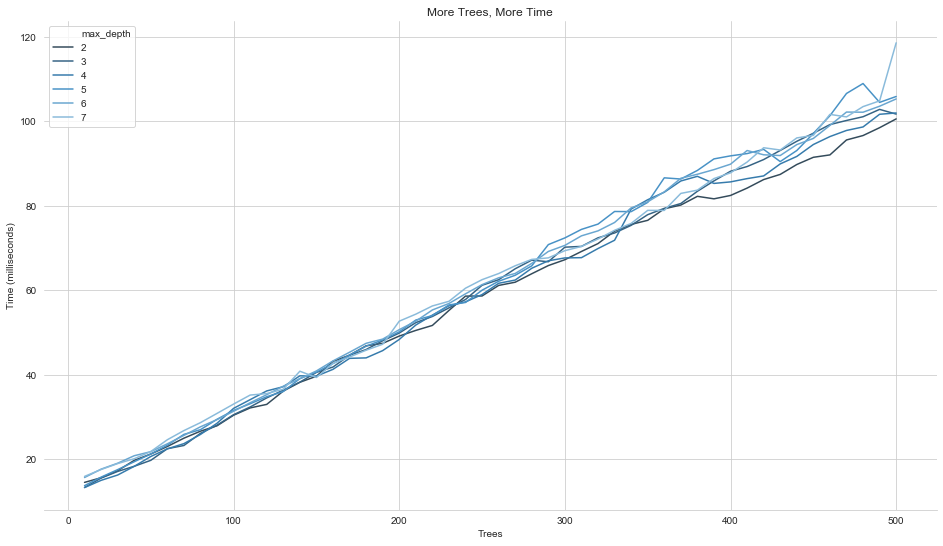

<IPython.core.display.Javascript object>

In [47]:
acc_speed_df = pd.DataFrame(
    {
        "trees": recorded_tree_counts,
        "max_depth": recorded_max_depths,
        "time": recorded_times,
        "score": recorded_scores,
    }
)
palette = sns.color_palette("Blues_d", acc_speed_df["max_depth"].nunique())
sns.set_style("whitegrid")

figure_is_widescreen()
sns.lineplot(data=acc_speed_df, x="trees", y="time", hue="max_depth", palette=palette)
plt.xlabel("Trees")
plt.ylabel("Time (milliseconds)")
despine_all()
plt.title("More Trees, More Time")
plt.show()

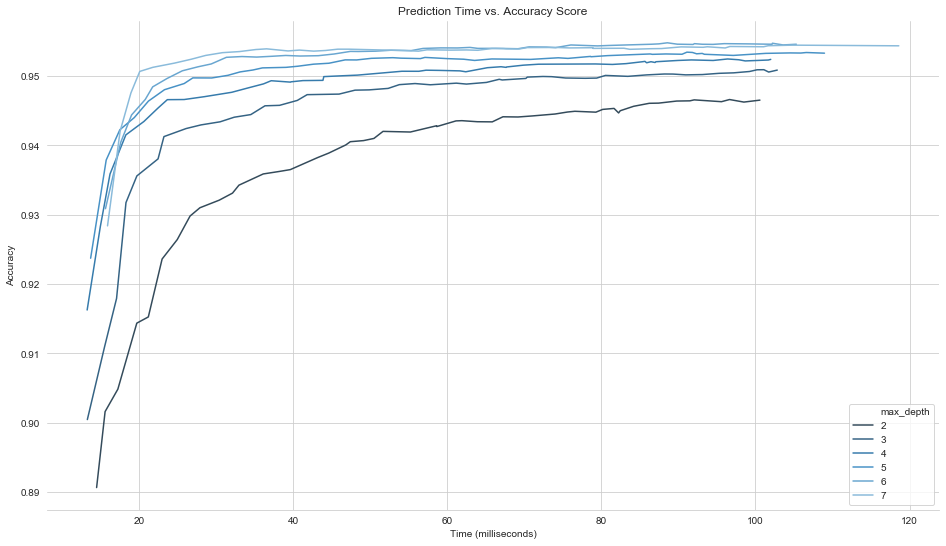

<IPython.core.display.Javascript object>

In [48]:
sns.set_style("whitegrid")
figure_is_widescreen()
sns.lineplot(data=acc_speed_df, x="time", y="score", hue="max_depth", palette=palette)
despine_all()
plt.xlabel("Time (milliseconds)")
plt.ylabel("Accuracy")
plt.title("Prediction Time vs. Accuracy Score")
plt.show()

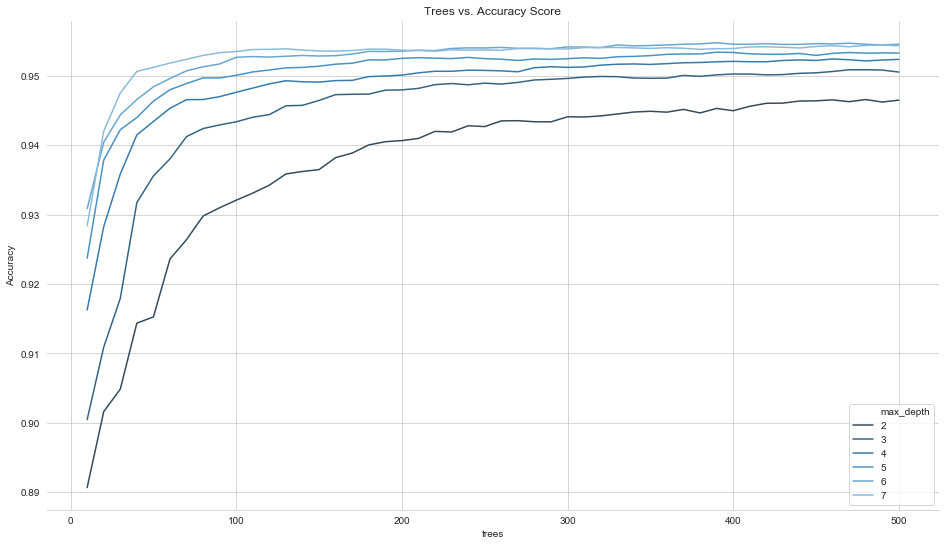

<IPython.core.display.Javascript object>

In [49]:
figure_is_widescreen()
sns.lineplot(data=acc_speed_df, x="trees", y="score", hue="max_depth", palette=palette)
despine_all()
plt.ylabel("Accuracy")
plt.title("Trees vs. Accuracy Score")
plt.show()

CatBoost - full modeling dataset: Train: 0.9575, Test: 0.9544
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     10037
    standing       0.93      0.94      0.94      9450
     walking       0.94      0.92      0.93      8792

    accuracy                           0.95     28279
   macro avg       0.95      0.95      0.95     28279
weighted avg       0.95      0.95      0.95     28279



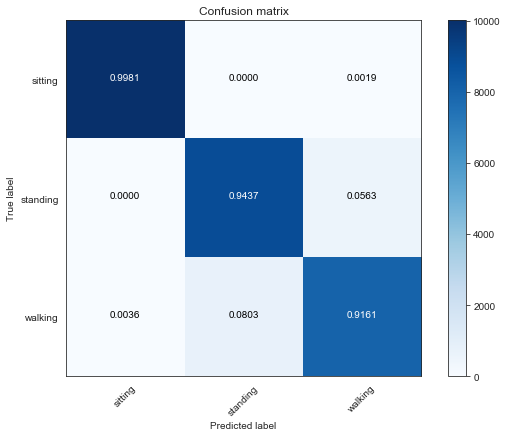

<IPython.core.display.Javascript object>

In [50]:
# fit CatBoost on full modeling set to confirm performance
cat_full_hyperparameters = {
    "learning_rate": 0.49712744837202827,
    "max_depth": 6,
    "n_estimators": 100,
    "verbose": False,
    "early_stopping_rounds": 49,
    "thread_count": -1,
}
cat_full = cb.CatBoostClassifier(**cat_full_hyperparameters)
cat_full.fit(X_model[thigh_columns], y_model)

_ = report_scores(
    cat_full,
    X_model[thigh_columns],
    y_model,
    X_eval[thigh_columns],
    y_eval,
    "CatBoost - full modeling dataset",
    labels=target_labels,
)

## Arm + Thigh Sensors

The combination of a phone with a smartwatch is increasingly common, so we test how good a model we can develop combining the thigh and arm sensors. The arm sensor in this data set was placed on the upper arm, not the wrist, so it isn't a perfect approximation of the data available with a smartwatch; but it's the data I have.

In [51]:
# Measure (adjusted, balanced) accuracy against tree sizes, counts, and predict times.
# Due to the iterative construction of Boosted models, we can test the accuracy for many
# different n_estimators values with one trained model.
arm_thigh = arm_columns + thigh_columns
tree_counts = np.arange(10, 501, 10)
max_depths = np.arange(2, 8)
n_timing_runs = 3

recorded_max_depths = []
recorded_tree_counts = []
recorded_times = []
recorded_scores = []

for d in max_depths:
    cat_hyperparameters["max_depth"] = d
    time_cat = cb.CatBoostClassifier(**cat_hyperparameters)
    time_cat.fit(X_train[arm_thigh], y_train)

    for n in tree_counts:
        run_times = []
        for _ in range(n_timing_runs):
            start = time.time()
            # thread_count=1 to approximate abilities of low-cost wearable hardware
            y_pred = time_cat.predict(X_test[arm_thigh], ntree_end=n, thread_count=1)
            elapsed = time.time() - start
            run_times.append(elapsed * 1000)  # milliseconds

        score = met.balanced_accuracy_score(y_test, y_pred)

        recorded_max_depths.append(d)
        recorded_tree_counts.append(n)
        recorded_times.append(min(run_times))
        recorded_scores.append(score)

<IPython.core.display.Javascript object>

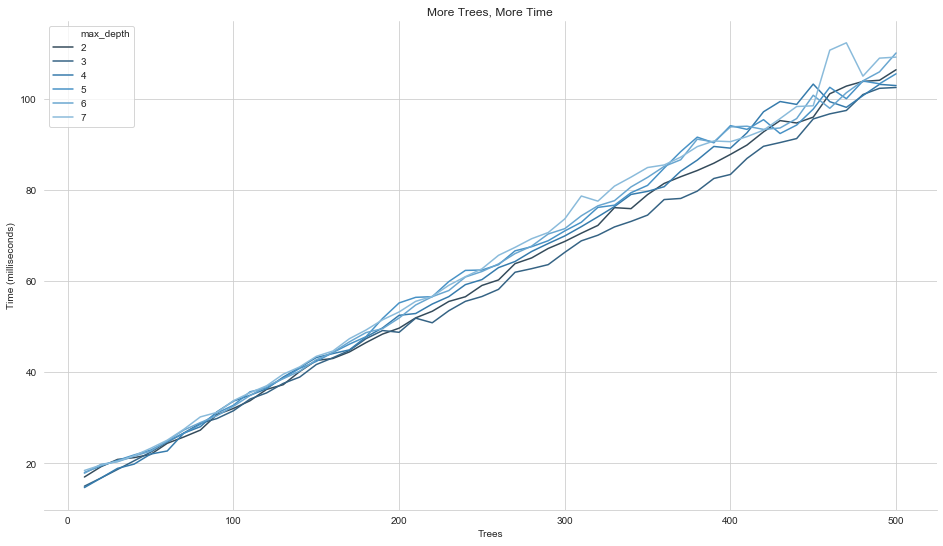

<IPython.core.display.Javascript object>

In [52]:
acc_speed2_df = pd.DataFrame(
    {
        "trees": recorded_tree_counts,
        "max_depth": recorded_max_depths,
        "time": recorded_times,
        "score": recorded_scores,
    }
)
palette = sns.color_palette("Blues_d", acc_speed2_df["max_depth"].nunique())
sns.set_style("whitegrid")

figure_is_widescreen()
sns.lineplot(data=acc_speed2_df, x="trees", y="time", hue="max_depth", palette=palette)
plt.xlabel("Trees")
plt.ylabel("Time (milliseconds)")
despine_all()
plt.title("More Trees, More Time")
plt.show()

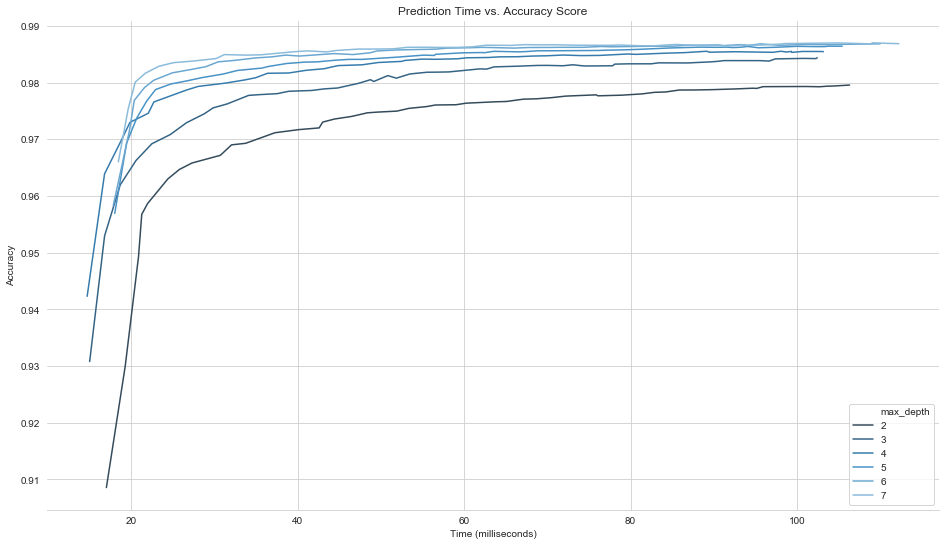

<IPython.core.display.Javascript object>

In [53]:
figure_is_widescreen()
sns.lineplot(data=acc_speed2_df, x="time", y="score", hue="max_depth", palette=palette)
despine_all()
plt.xlabel("Time (milliseconds)")
plt.ylabel("Accuracy")
plt.title("Prediction Time vs. Accuracy Score")
plt.show()

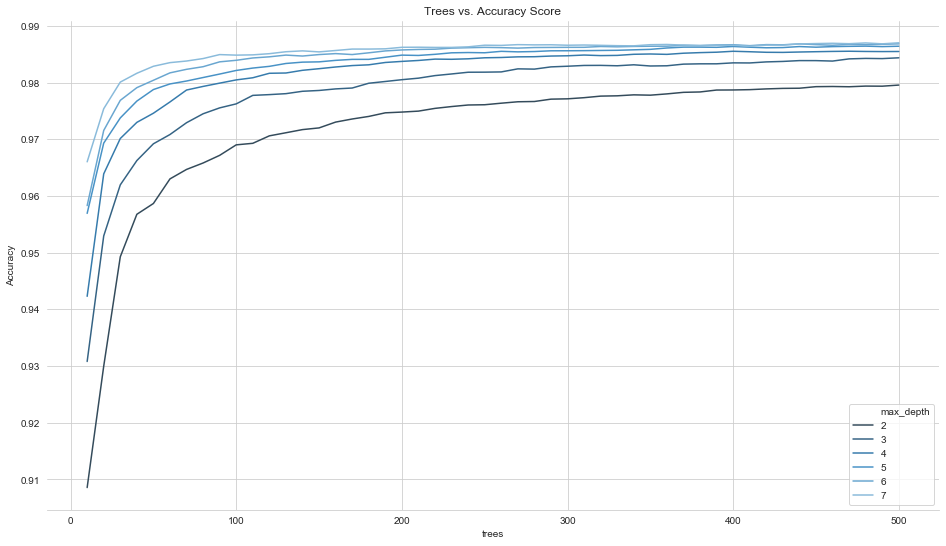

<IPython.core.display.Javascript object>

In [54]:
figure_is_widescreen()
sns.lineplot(data=acc_speed2_df, x="trees", y="score", hue="max_depth", palette=palette)
despine_all()
plt.ylabel("Accuracy")
plt.title("Trees vs. Accuracy Score")
plt.show()

In [55]:
# compare time/accuracy tradeoff for Thigh vs. Arm + Thigh
acc_speed_df["sensor"] = "Thigh"
acc_speed2_df["sensor"] = "Thigh + Arm"
acc_speed_combined = pd.concat([acc_speed_df, acc_speed2_df])

<IPython.core.display.Javascript object>

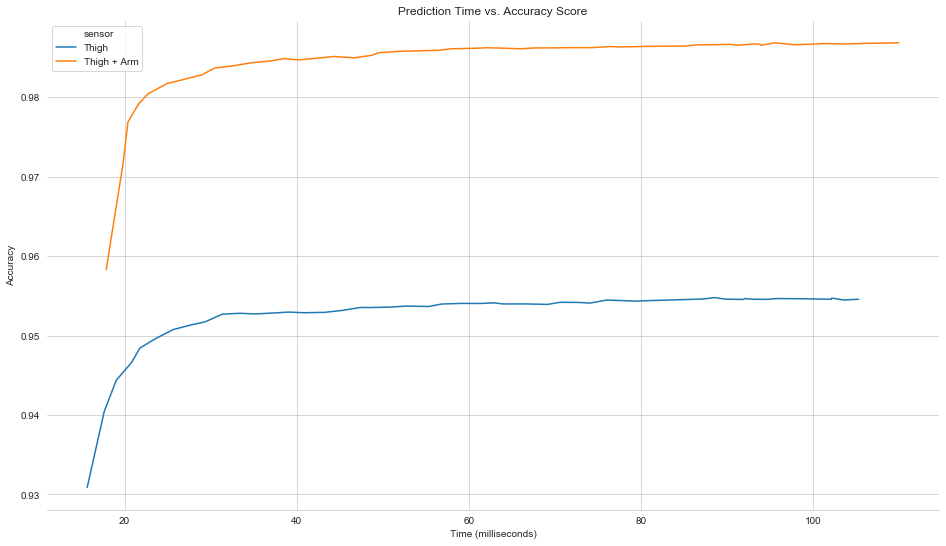

<IPython.core.display.Javascript object>

In [56]:
plot_data = acc_speed_combined[acc_speed_combined["max_depth"] == 6]

figure_is_widescreen()
sns.lineplot(data=plot_data, x="time", y="score", hue="sensor")
despine_all()
plt.xlabel("Time (milliseconds)")
plt.ylabel("Accuracy")
plt.title("Prediction Time vs. Accuracy Score")
plt.show()

CatBoost - full modeling dataset: Train: 0.9849, Test: 0.9833
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00     10037
    standing       0.97      0.98      0.98      9450
     walking       0.98      0.96      0.97      8792

    accuracy                           0.98     28279
   macro avg       0.98      0.98      0.98     28279
weighted avg       0.98      0.98      0.98     28279



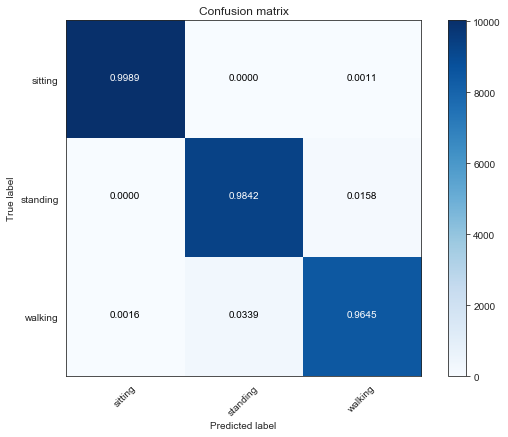

<IPython.core.display.Javascript object>

In [57]:
# fit CatBoost on full modeling set to confirm performance
cat_full_hyperparameters = {
    "learning_rate": 0.49712744837202827,
    "max_depth": 6,
    "n_estimators": 50,
    "verbose": False,
    "early_stopping_rounds": 49,
    "thread_count": -1,
}
cat_full = cb.CatBoostClassifier(**cat_full_hyperparameters)
cat_full.fit(X_model[arm_thigh], y_model)

_ = report_scores(
    cat_full,
    X_model[arm_thigh],
    y_model,
    X_eval[arm_thigh],
    y_eval,
    "CatBoost - full modeling dataset",
    labels=target_labels,
)